In [34]:
import numpy as np
import pandas as pd
import cv2
import os
import sys
import matplotlib.pyplot as plt
import torch

In [35]:
torch.cuda.get_device_name(0)
torch.cuda.is_available()

True

In [36]:
base_dir = "C:\project\EDIA\skin\data"
img_list = os.listdir(base_dir)

## Load Image, Preprocessing

### Preprocessing  
* RGB 각각의 value/255으로 각 값이 0에서 1사이 값을 가지게 normalize 한다.  

### Resize
* 모든 이미지를 256 * 256 사이즈로 만든다.

In [37]:
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms

In [38]:
trans_benign = transforms.Compose([transforms.Resize((128, 128)),
                           transforms.ToTensor(),
                            transforms.Normalize((0, 0, 0), (255, 255, 255))])

#trans_malig = transforms.Compose([transforms.Resize((256, 256)),
#                                 transforms.ToTensor(),
#                                 transforms.Normalize((0, 0, 0), (256, 256, 256))])

"""
trans_benign_without_normalize = transforms.Compose([transforms.Resize((256, 256)),
                                                   transforms.ToTensor()])
"""
trainset = torchvision.datasets.ImageFolder(root = base_dir, transform=trans_benign)
#trainset.__getitem__(1)
#classes = trainset.classes

print( trainset.__getitem__(1)[0][2])


"""
print("=====================")
trainset_without_normalize = torchvision.datasets.ImageFolder(root=base_dir, transform=trans_benign_without_normalize)

print(trainset_without_normalize.__getitem__(1)[0][0])
"""
#print(classes)
#print(len(trainset))

tensor([[0.0023, 0.0023, 0.0023,  ..., 0.0022, 0.0022, 0.0022],
        [0.0023, 0.0024, 0.0024,  ..., 0.0022, 0.0021, 0.0021],
        [0.0023, 0.0023, 0.0023,  ..., 0.0022, 0.0021, 0.0021],
        ...,
        [0.0019, 0.0019, 0.0020,  ..., 0.0016, 0.0015, 0.0014],
        [0.0019, 0.0019, 0.0019,  ..., 0.0016, 0.0014, 0.0014],
        [0.0018, 0.0019, 0.0019,  ..., 0.0015, 0.0014, 0.0013]])


'\nprint("=====================")\ntrainset_without_normalize = torchvision.datasets.ImageFolder(root=base_dir, transform=trans_benign_without_normalize)\n\nprint(trainset_without_normalize.__getitem__(1)[0][0])\n'

In [39]:
trainloader = DataLoader(trainset, batch_size=32, shuffle=False)
print(len(trainloader))
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(labels)

1036
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])


torch.Size([32, 3, 128, 128])
(3, 1042, 522)
(1042, 522, 3)
torch.Size([3, 522, 1042])


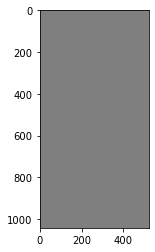

In [40]:
def imshow(img):
    img = img/2 + 0.5 #unnormalize
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    print(np_img.shape)
    print((np.transpose(np_img, (1,2,0))).shape)
        
print(images.shape)
imshow(torchvision.utils.make_grid(images, nrow=4))
print((torchvision.utils.make_grid(images)).shape)
#print("".join("%5s "%classes[labels[j]] for j in range(16)))             
    

## Construct Model

### Layer  
Encoder -> 5 convolutional block (128 x 128 size)  
Decoder -> 5 deconvolutional block (128 x 128 size)

### Optimizer
ADAM

### Batch_size
32

### Latent Dimension
300

### Learning Rate
1e-4

###  Epoch
40

In [41]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
batch_size = 32
learning_rate = 0.0001
EPOCH = 40

In [42]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        #conv layer depth from 1 -> 16
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        #conv layer depth from 16 -> 4
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        #pooling layer to reduce x-y dims by two : kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        
        #decode layer
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 1, 2, stride=2)
    
    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function and maxpooling after
        x= F.relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        ## decode ##
        # add transpose conv layers, with relu activation function
        x = F.relu(self.t_conv1(x))
        # output layer with sigmoid for scaling from 0 to 1
        x = F.sigmoid(self.t_conv2(x))
        
        return x

model = Autoencoder()
print(model)

Autoencoder(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
)


In [24]:
criterion = nn.MSELoss() ##Loss function 지정 필요
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [59]:
for epoch in range(1, EPOCH+1):
    #monitor training loss
    train_loss = 0.0
    
    for data in trainloader:
        # _ stands in for labels here
        # no need to flatten images
        images, _ = data
        #clear the gradients of all optimized variables
        optimizer.zero_grad()
        #forward pass : compute predicted outputs by passing inputs to the model
        outputs = model(images)
        #calculate the loss
        loss = criterion(outputs, images)
        #backward pass : compute gradient of the loss with respect to model parameters
        loss.backward()
        #perform a single optimization step (parameter update)
        optimizer.step()
        #update running traiing loss
        train_loss += loss.item()*images.size(0)
        print('.', end="")
    
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \t Training Loss : {:.6f}'.format(epoch, train_loss))

......................................................................

KeyboardInterrupt: 

In [47]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),# batch * 16 * 128 * 128
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, 3, padding=1),# batch * 32 * 128 * 128
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2)# batch * 32 * 64 * 64
        
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1), # batch * 64 * 64 * 64
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1), # batch * 128 * 32 * 32
            nn.ReLU()
        )
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(batch_size, -1)
        return out

In [48]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, 2, 1, 1),#batch * 64 * 64 * 64
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 32, 3, 1, 1), #batch * 32 * 64 * 64
            nn.ReLU(),
            nn.BatchNorm2d(32)
        )
        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, 1, 1), #batch * 16 * 64 * 64
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16, 3, 3, 2, 1, 1),#batch * 3 * 128 * 128
            nn.ReLU()
        )
    
    def forward(self, x):
        out = x.view(batch_size, 128, 32, 32)
        out = self.layer1(out)
        out = self.layer2(out)
        return out

In [49]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

encoder = Encoder().to(device)
decoder = Decoder().to(device)

parameters = list(encoder.parameters()) + list(decoder.parameters())
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(parameters, lr=learning_rate)

cuda:0


In [56]:
try:
    encoder, decoder = torch.load('./model/conv_autoencoder.pkl')
    print("\n--------model restored----------\n")
except:
    print("\n--------model initialize----------\n")
    pass

for i in range(EPOCH):
    for j, [image, label] in enumerate(trainloader):
        optimizer.zero_grad()
        image = image.to(device)
        
        output = encoder(image)
        print(output.size())
        output = decoder(output)
        
        loss = loss_func(output, image)
        loss.backward()
        optimizer.step()
        print(j, loss)
        if(j>1033): break
    #if(i>0): break
    
    torch.save([encoder, decoder], './model/conv_autoencoder.pkl')
    print(loss)


--------model restored----------

torch.Size([32, 131072])
0 tensor(0.0301, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
1 tensor(0.0296, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
2 tensor(0.0315, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
3 tensor(0.0310, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
4 tensor(0.0315, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
5 tensor(0.0315, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
6 tensor(0.0296, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
7 tensor(0.0296, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
8 tensor(0.0309, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
9 tensor(0.0309, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
10 tensor(0.0307, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 13

torch.Size([32, 131072])
94 tensor(0.0300, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
95 tensor(0.0303, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
96 tensor(0.0301, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
97 tensor(0.0304, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
98 tensor(0.0322, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
99 tensor(0.0312, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
100 tensor(0.0313, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
101 tensor(0.0304, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
102 tensor(0.0305, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
103 tensor(0.0313, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
104 tensor(0.0325, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
105 tensor(0.

torch.Size([32, 131072])
188 tensor(0.0310, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
189 tensor(0.0311, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
190 tensor(0.0306, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
191 tensor(0.0307, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
192 tensor(0.0295, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
193 tensor(0.0313, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
194 tensor(0.0303, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
195 tensor(0.0306, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
196 tensor(0.0309, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
197 tensor(0.0322, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
198 tensor(0.0299, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
199 ten

torch.Size([32, 131072])
282 tensor(0.0305, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
283 tensor(0.0317, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
284 tensor(0.0304, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
285 tensor(0.0300, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
286 tensor(0.0306, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
287 tensor(0.0311, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
288 tensor(0.0297, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
289 tensor(0.0310, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
290 tensor(0.0308, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
291 tensor(0.0304, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
292 tensor(0.0313, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
293 ten

torch.Size([32, 131072])
376 tensor(0.0319, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
377 tensor(0.0311, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
378 tensor(0.0301, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
379 tensor(0.0311, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
380 tensor(0.0311, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
381 tensor(0.0301, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
382 tensor(0.0308, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
383 tensor(0.0307, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
384 tensor(0.0309, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
385 tensor(0.0306, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
386 tensor(0.0302, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
387 ten

torch.Size([32, 131072])
470 tensor(0.0314, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
471 tensor(0.0304, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
472 tensor(0.0299, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
473 tensor(0.0304, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
474 tensor(0.0304, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
475 tensor(0.0307, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
476 tensor(0.0307, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
477 tensor(0.0309, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
478 tensor(0.0305, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
479 tensor(0.0294, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
480 tensor(0.0308, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
481 ten

torch.Size([32, 131072])
564 tensor(0.0303, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
565 tensor(0.0300, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
566 tensor(0.0313, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
567 tensor(0.0306, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
568 tensor(0.0299, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
569 tensor(0.0312, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
570 tensor(0.0302, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
571 tensor(0.0293, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
572 tensor(0.0309, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
573 tensor(0.0318, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
574 tensor(0.0305, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
575 ten

torch.Size([32, 131072])
658 tensor(0.0325, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
659 tensor(0.0308, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
660 tensor(0.0293, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
661 tensor(0.0304, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
662 tensor(0.0301, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
663 tensor(0.0308, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
664 tensor(0.0310, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
665 tensor(0.0311, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
666 tensor(0.0311, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
667 tensor(0.0303, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
668 tensor(0.0312, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
669 ten

torch.Size([32, 131072])
752 tensor(0.0298, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
753 tensor(0.0301, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
754 tensor(0.0298, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
755 tensor(0.0309, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
756 tensor(0.0306, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
757 tensor(0.0306, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
758 tensor(0.0303, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
759 tensor(0.0309, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
760 tensor(0.0310, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
761 tensor(0.0309, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
762 tensor(0.0320, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
763 ten

torch.Size([32, 131072])
846 tensor(0.0301, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
847 tensor(0.0310, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
848 tensor(0.0299, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
849 tensor(0.0301, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
850 tensor(0.0305, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
851 tensor(0.0308, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
852 tensor(0.0307, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
853 tensor(0.0305, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
854 tensor(0.0307, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
855 tensor(0.0319, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
856 tensor(0.0304, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
857 ten

torch.Size([32, 131072])
940 tensor(0.0303, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
941 tensor(0.0299, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
942 tensor(0.0303, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
943 tensor(0.0299, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
944 tensor(0.0295, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
945 tensor(0.0299, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
946 tensor(0.0304, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
947 tensor(0.0309, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
948 tensor(0.0316, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
949 tensor(0.0311, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
950 tensor(0.0298, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
951 ten

torch.Size([32, 131072])
1033 tensor(0.0345, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
1034 tensor(0.0374, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0374, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
0 tensor(0.0301, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
1 tensor(0.0296, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
2 tensor(0.0315, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
3 tensor(0.0310, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
4 tensor(0.0315, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
5 tensor(0.0315, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
6 tensor(0.0296, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
7 tensor(0.0296, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
8 tensor(0.0309, device='cuda:0', grad_fn=<MseLoss

torch.Size([32, 131072])
92 tensor(0.0309, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
93 tensor(0.0309, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
94 tensor(0.0300, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
95 tensor(0.0303, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
96 tensor(0.0301, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
97 tensor(0.0304, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
98 tensor(0.0322, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
99 tensor(0.0312, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
100 tensor(0.0313, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
101 tensor(0.0304, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
102 tensor(0.0305, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
103 tensor(0.03

torch.Size([32, 131072])
186 tensor(0.0309, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
187 tensor(0.0297, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
188 tensor(0.0310, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
189 tensor(0.0311, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
190 tensor(0.0306, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
191 tensor(0.0307, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
192 tensor(0.0295, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
193 tensor(0.0313, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
194 tensor(0.0303, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
195 tensor(0.0306, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
196 tensor(0.0309, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
197 ten

torch.Size([32, 131072])
280 tensor(0.0303, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
281 tensor(0.0314, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
282 tensor(0.0305, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
283 tensor(0.0317, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
284 tensor(0.0304, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
285 tensor(0.0300, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
286 tensor(0.0306, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
287 tensor(0.0311, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
288 tensor(0.0297, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
289 tensor(0.0310, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
290 tensor(0.0308, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
291 ten

torch.Size([32, 131072])
374 tensor(0.0315, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
375 tensor(0.0311, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
376 tensor(0.0319, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
377 tensor(0.0311, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
378 tensor(0.0301, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
379 tensor(0.0311, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
380 tensor(0.0311, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
381 tensor(0.0301, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
382 tensor(0.0308, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
383 tensor(0.0307, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
384 tensor(0.0309, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
385 ten

torch.Size([32, 131072])
468 tensor(0.0319, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
469 tensor(0.0309, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
470 tensor(0.0314, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
471 tensor(0.0304, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
472 tensor(0.0299, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
473 tensor(0.0304, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
474 tensor(0.0304, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
475 tensor(0.0307, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
476 tensor(0.0307, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
477 tensor(0.0309, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
478 tensor(0.0305, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
479 ten

torch.Size([32, 131072])
562 tensor(0.0324, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
563 tensor(0.0313, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
564 tensor(0.0303, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
565 tensor(0.0300, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
566 tensor(0.0313, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
567 tensor(0.0306, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
568 tensor(0.0299, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
569 tensor(0.0312, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
570 tensor(0.0302, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
571 tensor(0.0293, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
572 tensor(0.0309, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
573 ten

torch.Size([32, 131072])
656 tensor(0.0308, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
657 tensor(0.0294, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
658 tensor(0.0325, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
659 tensor(0.0308, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
660 tensor(0.0293, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
661 tensor(0.0304, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
662 tensor(0.0301, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
663 tensor(0.0308, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
664 tensor(0.0310, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
665 tensor(0.0311, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
666 tensor(0.0311, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
667 ten

torch.Size([32, 131072])
750 tensor(0.0320, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
751 tensor(0.0321, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
752 tensor(0.0298, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
753 tensor(0.0301, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
754 tensor(0.0298, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
755 tensor(0.0309, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
756 tensor(0.0306, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
757 tensor(0.0306, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
758 tensor(0.0303, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
759 tensor(0.0309, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
760 tensor(0.0310, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
761 ten

torch.Size([32, 131072])
844 tensor(0.0316, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
845 tensor(0.0297, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
846 tensor(0.0301, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
847 tensor(0.0310, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
848 tensor(0.0299, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
849 tensor(0.0301, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
850 tensor(0.0305, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
851 tensor(0.0308, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
852 tensor(0.0307, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
853 tensor(0.0305, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
854 tensor(0.0307, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
855 ten

torch.Size([32, 131072])
938 tensor(0.0304, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
939 tensor(0.0311, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
940 tensor(0.0303, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
941 tensor(0.0299, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
942 tensor(0.0303, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
943 tensor(0.0299, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
944 tensor(0.0295, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
945 tensor(0.0299, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
946 tensor(0.0304, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
947 tensor(0.0309, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
948 tensor(0.0316, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
949 ten

torch.Size([32, 131072])
1031 tensor(0.0343, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
1032 tensor(0.0342, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
1033 tensor(0.0345, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
1034 tensor(0.0374, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0374, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
0 tensor(0.0301, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
1 tensor(0.0296, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
2 tensor(0.0315, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
3 tensor(0.0310, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
4 tensor(0.0315, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
5 tensor(0.0315, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
6 tensor(0.0296, device='cuda:0', grad_fn=<M

torch.Size([32, 131072])
90 tensor(0.0301, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
91 tensor(0.0309, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
92 tensor(0.0309, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
93 tensor(0.0309, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
94 tensor(0.0300, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
95 tensor(0.0303, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
96 tensor(0.0301, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
97 tensor(0.0304, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
98 tensor(0.0322, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
99 tensor(0.0312, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
100 tensor(0.0313, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
101 tensor(0.0304

torch.Size([32, 131072])
184 tensor(0.0306, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
185 tensor(0.0298, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
186 tensor(0.0309, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
187 tensor(0.0297, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
188 tensor(0.0310, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
189 tensor(0.0311, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
190 tensor(0.0306, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
191 tensor(0.0307, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
192 tensor(0.0295, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
193 tensor(0.0313, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
194 tensor(0.0303, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
195 ten

torch.Size([32, 131072])
278 tensor(0.0308, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
279 tensor(0.0304, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
280 tensor(0.0303, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
281 tensor(0.0314, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
282 tensor(0.0305, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
283 tensor(0.0317, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
284 tensor(0.0304, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
285 tensor(0.0300, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
286 tensor(0.0306, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
287 tensor(0.0311, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
288 tensor(0.0297, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
289 ten

torch.Size([32, 131072])
372 tensor(0.0304, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
373 tensor(0.0309, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
374 tensor(0.0315, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
375 tensor(0.0311, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
376 tensor(0.0319, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
377 tensor(0.0311, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
378 tensor(0.0301, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
379 tensor(0.0311, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
380 tensor(0.0311, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
381 tensor(0.0301, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
382 tensor(0.0308, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
383 ten

torch.Size([32, 131072])
466 tensor(0.0301, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
467 tensor(0.0303, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
468 tensor(0.0319, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
469 tensor(0.0309, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
470 tensor(0.0314, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
471 tensor(0.0304, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
472 tensor(0.0299, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
473 tensor(0.0304, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
474 tensor(0.0304, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
475 tensor(0.0307, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
476 tensor(0.0307, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
477 ten

torch.Size([32, 131072])
560 tensor(0.0308, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
561 tensor(0.0314, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
562 tensor(0.0324, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
563 tensor(0.0313, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
564 tensor(0.0303, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
565 tensor(0.0300, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
566 tensor(0.0313, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
567 tensor(0.0306, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
568 tensor(0.0299, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
569 tensor(0.0312, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
570 tensor(0.0302, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
571 ten

torch.Size([32, 131072])
654 tensor(0.0298, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
655 tensor(0.0301, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
656 tensor(0.0308, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
657 tensor(0.0294, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
658 tensor(0.0325, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
659 tensor(0.0308, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
660 tensor(0.0293, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
661 tensor(0.0304, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
662 tensor(0.0301, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
663 tensor(0.0308, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
664 tensor(0.0310, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
665 ten

torch.Size([32, 131072])
748 tensor(0.0320, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
749 tensor(0.0307, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
750 tensor(0.0320, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
751 tensor(0.0321, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
752 tensor(0.0298, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
753 tensor(0.0301, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
754 tensor(0.0298, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
755 tensor(0.0309, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
756 tensor(0.0306, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
757 tensor(0.0306, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
758 tensor(0.0303, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
759 ten

torch.Size([32, 131072])
842 tensor(0.0309, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
843 tensor(0.0294, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
844 tensor(0.0316, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
845 tensor(0.0297, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
846 tensor(0.0301, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
847 tensor(0.0310, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
848 tensor(0.0299, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
849 tensor(0.0301, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
850 tensor(0.0305, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
851 tensor(0.0308, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
852 tensor(0.0307, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
853 ten

torch.Size([32, 131072])
936 tensor(0.0324, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
937 tensor(0.0310, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
938 tensor(0.0304, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
939 tensor(0.0311, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
940 tensor(0.0303, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
941 tensor(0.0299, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
942 tensor(0.0303, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
943 tensor(0.0299, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
944 tensor(0.0295, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
945 tensor(0.0299, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
946 tensor(0.0304, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
947 ten

torch.Size([32, 131072])
1029 tensor(0.0349, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
1030 tensor(0.0347, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
1031 tensor(0.0343, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
1032 tensor(0.0342, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
1033 tensor(0.0345, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
1034 tensor(0.0374, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0374, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
0 tensor(0.0301, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
1 tensor(0.0296, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
2 tensor(0.0315, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
3 tensor(0.0310, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
4 tensor(0.0315, device='cuda:0', grad

torch.Size([32, 131072])
88 tensor(0.0301, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
89 tensor(0.0306, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
90 tensor(0.0301, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
91 tensor(0.0309, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
92 tensor(0.0309, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
93 tensor(0.0309, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
94 tensor(0.0300, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
95 tensor(0.0303, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
96 tensor(0.0301, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
97 tensor(0.0304, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
98 tensor(0.0322, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
99 tensor(0.0312, 

torch.Size([32, 131072])
182 tensor(0.0305, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
183 tensor(0.0304, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
184 tensor(0.0306, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
185 tensor(0.0298, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
186 tensor(0.0309, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
187 tensor(0.0297, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
188 tensor(0.0310, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
189 tensor(0.0311, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
190 tensor(0.0306, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
191 tensor(0.0307, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
192 tensor(0.0295, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
193 ten

torch.Size([32, 131072])
276 tensor(0.0305, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
277 tensor(0.0307, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
278 tensor(0.0308, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
279 tensor(0.0304, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
280 tensor(0.0303, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
281 tensor(0.0314, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
282 tensor(0.0305, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
283 tensor(0.0317, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
284 tensor(0.0304, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
285 tensor(0.0300, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
286 tensor(0.0306, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
287 ten

torch.Size([32, 131072])
370 tensor(0.0316, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
371 tensor(0.0330, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
372 tensor(0.0304, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
373 tensor(0.0309, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
374 tensor(0.0315, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
375 tensor(0.0311, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
376 tensor(0.0319, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
377 tensor(0.0311, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
378 tensor(0.0301, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
379 tensor(0.0311, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
380 tensor(0.0311, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
381 ten

torch.Size([32, 131072])
464 tensor(0.0297, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
465 tensor(0.0305, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
466 tensor(0.0301, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
467 tensor(0.0303, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
468 tensor(0.0319, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
469 tensor(0.0309, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
470 tensor(0.0314, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
471 tensor(0.0304, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
472 tensor(0.0299, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
473 tensor(0.0304, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
474 tensor(0.0304, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
475 ten

torch.Size([32, 131072])
558 tensor(0.0313, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
559 tensor(0.0304, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
560 tensor(0.0308, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
561 tensor(0.0314, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
562 tensor(0.0324, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
563 tensor(0.0313, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
564 tensor(0.0303, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
565 tensor(0.0300, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
566 tensor(0.0313, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
567 tensor(0.0306, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
568 tensor(0.0299, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
569 ten

torch.Size([32, 131072])
652 tensor(0.0326, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
653 tensor(0.0296, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
654 tensor(0.0298, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
655 tensor(0.0301, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
656 tensor(0.0308, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
657 tensor(0.0294, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
658 tensor(0.0325, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
659 tensor(0.0308, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
660 tensor(0.0293, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
661 tensor(0.0304, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
662 tensor(0.0301, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
663 ten

torch.Size([32, 131072])
746 tensor(0.0303, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
747 tensor(0.0295, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
748 tensor(0.0320, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
749 tensor(0.0307, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
750 tensor(0.0320, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
751 tensor(0.0321, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
752 tensor(0.0298, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
753 tensor(0.0301, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
754 tensor(0.0298, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
755 tensor(0.0309, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
756 tensor(0.0306, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
757 ten

torch.Size([32, 131072])
840 tensor(0.0299, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
841 tensor(0.0302, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
842 tensor(0.0309, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
843 tensor(0.0294, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
844 tensor(0.0316, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
845 tensor(0.0297, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
846 tensor(0.0301, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
847 tensor(0.0310, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
848 tensor(0.0299, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
849 tensor(0.0301, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
850 tensor(0.0305, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
851 ten

torch.Size([32, 131072])
934 tensor(0.0307, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
935 tensor(0.0309, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
936 tensor(0.0324, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
937 tensor(0.0310, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
938 tensor(0.0304, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
939 tensor(0.0311, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
940 tensor(0.0303, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
941 tensor(0.0299, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
942 tensor(0.0303, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
943 tensor(0.0299, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
944 tensor(0.0295, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
945 ten

torch.Size([32, 131072])
1027 tensor(0.0344, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
1028 tensor(0.0324, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
1029 tensor(0.0349, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
1030 tensor(0.0347, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
1031 tensor(0.0343, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
1032 tensor(0.0342, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
1033 tensor(0.0345, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
1034 tensor(0.0374, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0374, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
0 tensor(0.0301, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
1 tensor(0.0296, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
2 tensor(0.0315, device='cuda:0'

torch.Size([32, 131072])
86 tensor(0.0305, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
87 tensor(0.0311, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
88 tensor(0.0301, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
89 tensor(0.0306, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
90 tensor(0.0301, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
91 tensor(0.0309, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
92 tensor(0.0309, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
93 tensor(0.0309, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
94 tensor(0.0300, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
95 tensor(0.0303, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
96 tensor(0.0301, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
97 tensor(0.0304, 

torch.Size([32, 131072])
180 tensor(0.0303, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
181 tensor(0.0310, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
182 tensor(0.0305, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
183 tensor(0.0304, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
184 tensor(0.0306, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
185 tensor(0.0298, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
186 tensor(0.0309, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
187 tensor(0.0297, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
188 tensor(0.0310, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
189 tensor(0.0311, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
190 tensor(0.0306, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
191 ten

torch.Size([32, 131072])
274 tensor(0.0302, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
275 tensor(0.0310, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
276 tensor(0.0305, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
277 tensor(0.0307, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
278 tensor(0.0308, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
279 tensor(0.0304, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
280 tensor(0.0303, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
281 tensor(0.0314, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
282 tensor(0.0305, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
283 tensor(0.0317, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
284 tensor(0.0304, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
285 ten

torch.Size([32, 131072])
368 tensor(0.0299, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
369 tensor(0.0306, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
370 tensor(0.0316, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
371 tensor(0.0330, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
372 tensor(0.0304, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
373 tensor(0.0309, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
374 tensor(0.0315, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
375 tensor(0.0311, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
376 tensor(0.0319, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
377 tensor(0.0311, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
378 tensor(0.0301, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
379 ten

torch.Size([32, 131072])
462 tensor(0.0309, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
463 tensor(0.0312, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
464 tensor(0.0297, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
465 tensor(0.0305, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
466 tensor(0.0301, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
467 tensor(0.0303, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
468 tensor(0.0319, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
469 tensor(0.0309, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
470 tensor(0.0314, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
471 tensor(0.0304, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
472 tensor(0.0299, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
473 ten

torch.Size([32, 131072])
556 tensor(0.0330, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
557 tensor(0.0298, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
558 tensor(0.0313, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
559 tensor(0.0304, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
560 tensor(0.0308, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
561 tensor(0.0314, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
562 tensor(0.0324, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
563 tensor(0.0313, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
564 tensor(0.0303, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
565 tensor(0.0300, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
566 tensor(0.0313, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
567 ten

torch.Size([32, 131072])
650 tensor(0.0305, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
651 tensor(0.0310, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
652 tensor(0.0326, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
653 tensor(0.0296, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
654 tensor(0.0298, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
655 tensor(0.0301, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
656 tensor(0.0308, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
657 tensor(0.0294, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
658 tensor(0.0325, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
659 tensor(0.0308, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
660 tensor(0.0293, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
661 ten

torch.Size([32, 131072])
744 tensor(0.0332, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
745 tensor(0.0318, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
746 tensor(0.0303, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
747 tensor(0.0295, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
748 tensor(0.0320, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
749 tensor(0.0307, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
750 tensor(0.0320, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
751 tensor(0.0321, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
752 tensor(0.0298, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
753 tensor(0.0301, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
754 tensor(0.0298, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
755 ten

torch.Size([32, 131072])
838 tensor(0.0308, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
839 tensor(0.0308, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
840 tensor(0.0299, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
841 tensor(0.0302, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
842 tensor(0.0309, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
843 tensor(0.0294, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
844 tensor(0.0316, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
845 tensor(0.0297, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
846 tensor(0.0301, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
847 tensor(0.0310, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
848 tensor(0.0299, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
849 ten

torch.Size([32, 131072])
932 tensor(0.0303, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
933 tensor(0.0306, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
934 tensor(0.0307, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
935 tensor(0.0309, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
936 tensor(0.0324, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
937 tensor(0.0310, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
938 tensor(0.0304, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
939 tensor(0.0311, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
940 tensor(0.0303, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
941 tensor(0.0299, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
942 tensor(0.0303, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
943 ten

torch.Size([32, 131072])
1025 tensor(0.0347, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
1026 tensor(0.0340, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
1027 tensor(0.0344, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
1028 tensor(0.0324, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
1029 tensor(0.0349, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
1030 tensor(0.0347, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
1031 tensor(0.0343, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
1032 tensor(0.0342, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
1033 tensor(0.0345, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
1034 tensor(0.0374, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0374, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([32, 131072])
0 tensor(0.0301, device='c

KeyboardInterrupt: 